# DESAFIO DO TELECOM X2 - churn PREDICT #

🛠️ Preparação dos Dados

Importando as bibliotecas do projeto

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb

Extração do Arquivo Tratado

In [33]:
import pandas as pd
telecom_dados = pd.read_csv('TelecomX_Data_Clean.csv', sep=';')
telecom_dados.head()


,Churn,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,DailyCharges,MonthlyCharges,AvgServiceCost,TotalCharges,ServiceCount,TenureGroup,Churn_binary
0,No,Female,No,Yes,Yes,9,Yes,No,Dsl,No,...,One year,Yes,Mailed check,"65,92","65,6","16,4","593,3",4,0–12,0
1,No,Male,No,No,No,9,Yes,Yes,Dsl,No,...,Month-to-month,No,Mailed check,"60,27","59,9","29,95","542,4",2,0–12,0
2,Yes,Male,No,No,No,4,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,"70,21","73,9","36,95","280,85",2,0–12,1
3,Yes,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,"95,22","98,0","19,6","1237,85",5,13–24,1
4,Yes,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Mailed check,"89,13","83,9","27,96666666666667","267,4",3,0–12,1


In [34]:
telecom_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Churn             7032 non-null   object
 1   Gender            7032 non-null   object
 2   SeniorCitizen     7032 non-null   object
 3   Partner           7032 non-null   object
 4   Dependents        7032 non-null   object
 5   Tenure            7032 non-null   int64 
 6   PhoneService      7032 non-null   object
 7   MultipleLines     7032 non-null   object
 8   InternetService   7032 non-null   object
 9   OnlineSecurity    7032 non-null   object
 10  OnlineBackup      7032 non-null   object
 11  DeviceProtection  7032 non-null   object
 12  TechSupport       7032 non-null   object
 13  StreamingTV       7032 non-null   object
 14  StreamingMovies   7032 non-null   object
 15  Contract          7032 non-null   object
 16  PaperlessBilling  7032 non-null   object
 17  PaymentMethod 

In [35]:
telecom_dados = pd.read_csv('TelecomX_Data_Clean.csv', sep=';')
print(telecom_dados.columns)
print(telecom_dados['Churn'].unique())
print(telecom_dados['Churn'].value_counts())

Index(['Churn', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'DailyCharges', 'MonthlyCharges', 'AvgServiceCost', 'TotalCharges',
       'ServiceCount', 'TenureGroup', 'Churn_binary'],
      dtype='object')
['No' 'Yes']
Churn
No     5163
Yes    1869
Name: count, dtype: int64


Remoção de Colunas Irrelevantes

In [36]:
#Total de Valores Faltantes
print(f'Total de Valores faltantes na tabela: \n{telecom_dados.isnull().sum()}')

Total de Valores faltantes na tabela: 
Churn                0
Gender               0
SeniorCitizen        0
Partner              0
Dependents           0
Tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
DailyCharges         0
MonthlyCharges       0
AvgServiceCost      80
TotalCharges         0
ServiceCount         0
TenureGroup          0
Churn_binary         0
dtype: int64


Encoding

In [37]:
telecom_dados['Churn_binary'].isnull()
print(telecom_dados['Churn_binary'].isnull().sum())

0


In [45]:
# Remover linhas com valores nulos na variável alvo
telecom_dados = telecom_dados.dropna(subset=['Churn']).copy()

# Converter Churn para binário
telecom_dados['Churn_binary'] = telecom_dados['Churn'].map({'Yes': 1, 'No': 0})

# Ajuste de vírgulas para pontos em colunas numéricas que vieram como string
for col in ['TotalCharges', 'AvgServiceCost']:
    telecom_dados[col] = telecom_dados[col].astype(str).str.replace(',', '.', regex=False).astype(float)

# Preencher valores faltantes na AvgServiceCost com mediana
telecom_dados['AvgServiceCost'] = telecom_dados['AvgServiceCost'].fillna(telecom_dados['AvgServiceCost'].median())


In [39]:
print(telecom_dados['Churn_binary'].head())
print(telecom_dados['Churn_binary'].isnull().sum())
print(telecom_dados['Churn_binary'].unique())

0    0
1    0
2    1
3    1
4    1
Name: Churn_binary, dtype: int64
0
[0 1]


Verificação da Proporção de Evasão

In [40]:
telecom_churn = telecom_dados['Churn_binary'].mean()
print(f"Proporção de clientes que evadiram: {telecom_churn:.2%}")

Proporção de clientes que evadiram: 26.58%


Balanceamento de Classes (opcional )

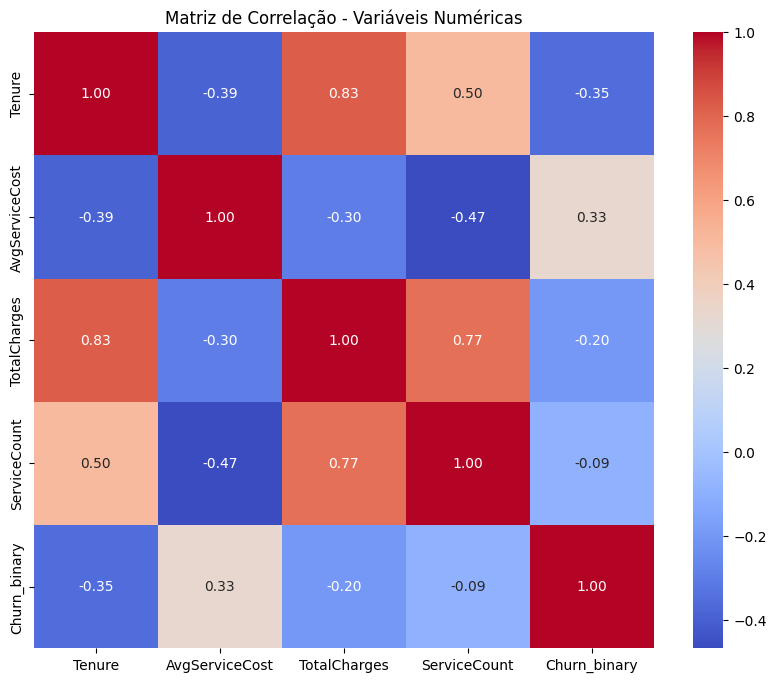

In [41]:
corr = telecom_dados.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Matriz de Correlação - Variáveis Numéricas")
plt.show()

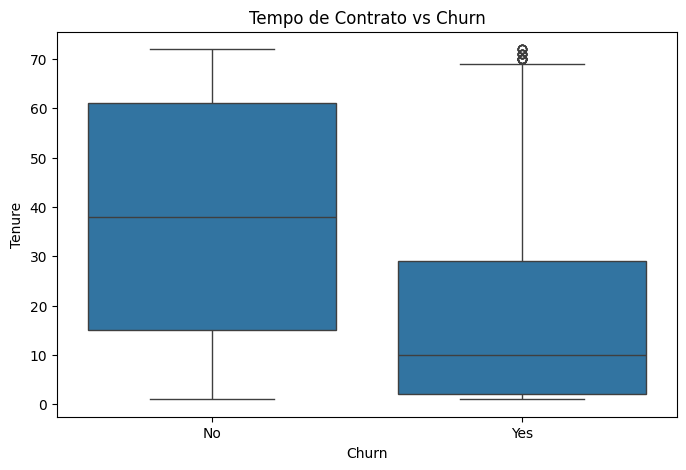

In [54]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='Tenure', data=telecom_dados)
plt.title("Tempo de Contrato vs Churn")
plt.show()

In [48]:
print(telecom_dados['TotalCharges'].dtype)
print(telecom_dados['TotalCharges'].head())
print(telecom_dados['TotalCharges'].describe())

float64
0     593.30
1     542.40
2     280.85
3    1237.85
4     267.40
Name: TotalCharges, dtype: float64
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


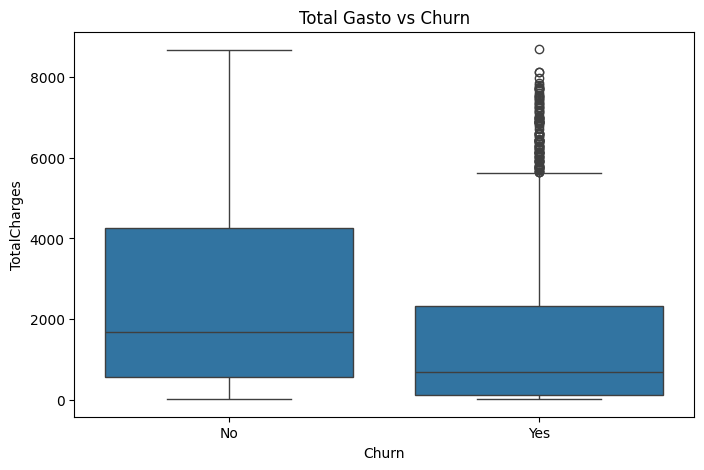

In [49]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='TotalCharges', data=telecom_dados)
plt.title("Total Gasto vs Churn")
plt.show()

Codificação de variáveis categóricas

In [56]:
categoricas = telecom_dados.select_dtypes(include=['object']).columns.tolist()
dados_encoded = pd.get_dummies(telecom_dados, columns=categoricas, drop_first=True)

X = dados_encoded.drop(['Churn_binary'], axis=1)
y = dados_encoded['Churn_binary']

print(f"Dimensão dos dados após get_dummies: {dados_encoded.shape}")

Dimensão dos dados após get_dummies: (7032, 6190)


Divisão Treino e Teste

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Proporção treino/teste: {1 - 0.3:.1f} / {0.3:.1f}")

Proporção treino/teste: 0.7 / 0.3


Balanceamento com SMOTE e Undersampling

In [58]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print(f"Distribuição após SMOTE: {np.bincount(y_train_bal)}")
print(f"Distribuição após undersampling: {np.bincount(y_train_rus)}")

Distribuição após SMOTE: [3614 3614]
Distribuição após undersampling: [1308 1308]


Normalização para modelos que requerem (regressão logística, KNN, SVM)

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

Redução de dimensionalidade (PCA) para KNN/SVM

In [60]:
pca = PCA(n_components=50, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Treinamento dos Modelos

Regressão Logística (normalizado)

In [61]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train_bal)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

KNN (normalizado + PCA)

In [62]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pca, y_train_bal)
y_pred_knn = knn.predict(X_test_pca)
y_proba_knn = knn.predict_proba(X_test_pca)[:, 1]

SVM (normalizado + PCA)

In [63]:
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_pca, y_train_bal)
y_pred_svm = svm.predict(X_test_pca)
y_proba_svm = svm.predict_proba(X_test_pca)[:, 1]

Random Forest (sem normalização)

In [64]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

Avaliação dos Modelos


--- Avaliação do Modelo: Regressão Logística ---
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1549
           1       0.98      0.92      0.95       561

    accuracy                           0.97      2110
   macro avg       0.97      0.96      0.96      2110
weighted avg       0.97      0.97      0.97      2110



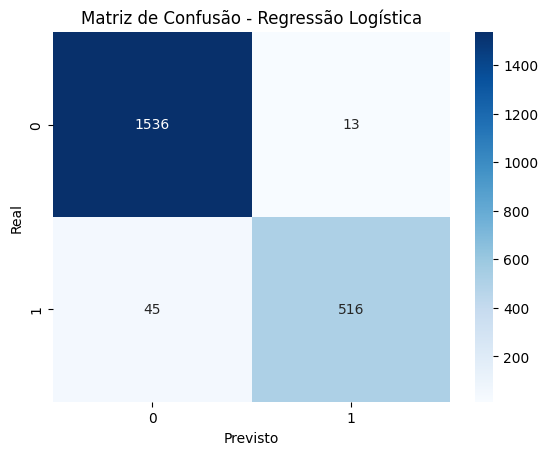


--- Avaliação do Modelo: KNN ---
              precision    recall  f1-score   support

           0       0.76      0.98      0.86      1549
           1       0.71      0.15      0.24       561

    accuracy                           0.76      2110
   macro avg       0.73      0.56      0.55      2110
weighted avg       0.75      0.76      0.69      2110



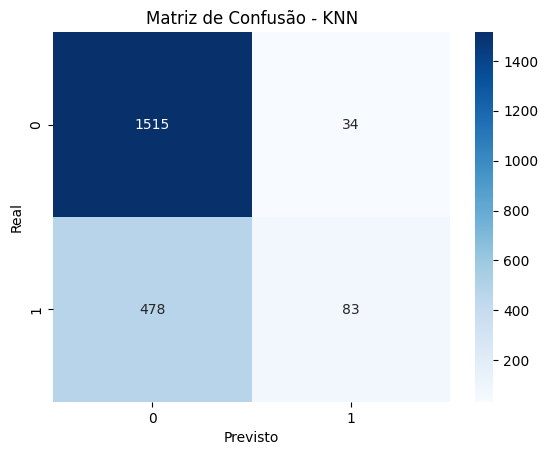


--- Avaliação do Modelo: SVM ---
              precision    recall  f1-score   support

           0       0.80      0.97      0.87      1549
           1       0.79      0.32      0.46       561

    accuracy                           0.80      2110
   macro avg       0.79      0.64      0.67      2110
weighted avg       0.80      0.80      0.76      2110



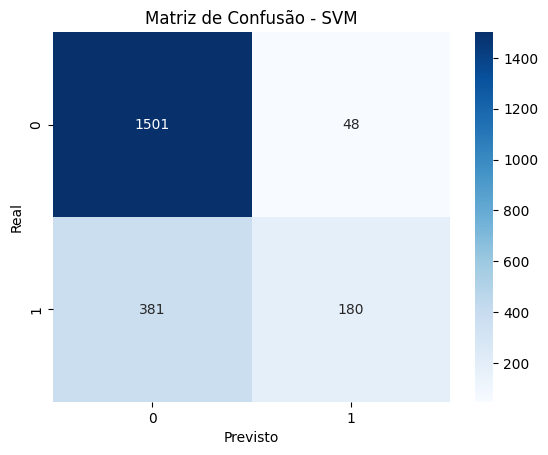


--- Avaliação do Modelo: Random Forest ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1549
           1       1.00      0.97      0.98       561

    accuracy                           0.99      2110
   macro avg       0.99      0.98      0.99      2110
weighted avg       0.99      0.99      0.99      2110



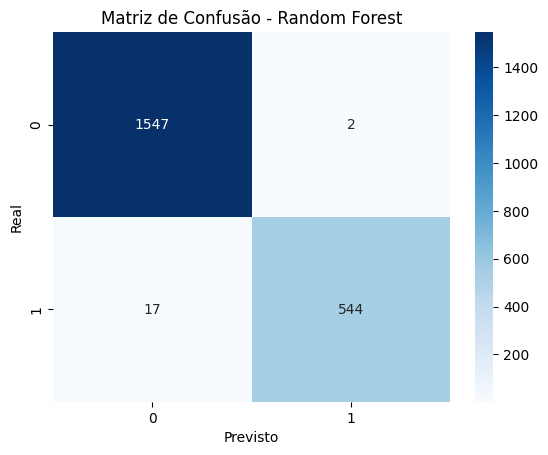

In [65]:
def avaliar_modelo(nome, y_true, y_pred, y_proba):
    print(f"\n--- Avaliação do Modelo: {nome} ---")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {nome}')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()

    resultados = {
        'Modelo': nome,
        'Acurácia': accuracy_score(y_true, y_pred),
        'Precisão': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_proba)
    }
    return resultados

resultados = []
resultados.append(avaliar_modelo('Regressão Logística', y_test, y_pred_lr, y_proba_lr))
resultados.append(avaliar_modelo('KNN', y_test, y_pred_knn, y_proba_knn))
resultados.append(avaliar_modelo('SVM', y_test, y_pred_svm, y_proba_svm))
resultados.append(avaliar_modelo('Random Forest', y_test, y_pred_rf, y_proba_rf))

Treinamento e avaliação do XGBoost (sem normalização)


--- Avaliação do Modelo: XGBoost ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1549
           1       1.00      1.00      1.00       561

    accuracy                           1.00      2110
   macro avg       1.00      1.00      1.00      2110
weighted avg       1.00      1.00      1.00      2110



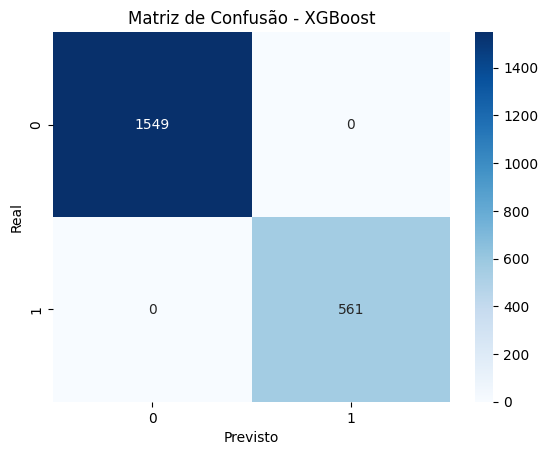

In [66]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
resultados.append(avaliar_modelo('XGBoost', y_test, y_pred_xgb, y_proba_xgb))

Importância das variáveis

In [67]:
importances_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
coef_lr = pd.Series(lr.coef_[0], index=X.columns).sort_values(ascending=False)

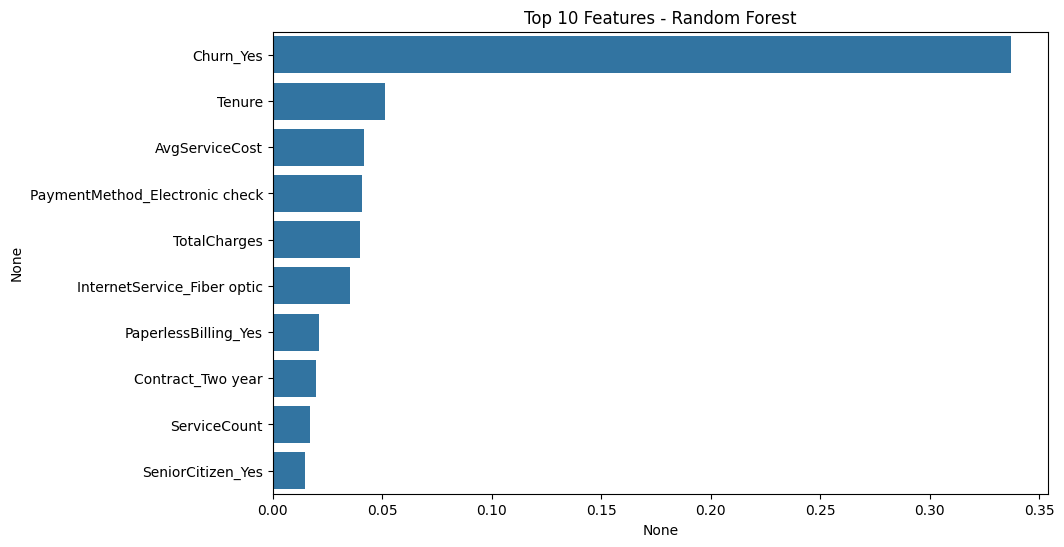

In [68]:
values = importances_rf[:10].values
features = importances_rf.index[:10]
colors = plt.cm.viridis(np.linspace(0, 1, len(values)))

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_rf[:10], y=importances_rf.index[:10])
plt.title('Top 10 Features - Random Forest')
plt.show()

In [69]:
# Logistic Regression - top 10 coeficientes positivos e negativos
coef_lr_df = pd.DataFrame({
    'Variável': X.columns,
    'Coeficiente': lr.coef_[0]
}).sort_values(by='Coeficiente', ascending=False)

print("\n🔍 Top 10 variáveis com maior coeficiente positivo (Regressão Logística):\n", coef_lr_df.head(10))
print("\n🔍 Top 10 variáveis com maior coeficiente negativo (Regressão Logística):\n", coef_lr_df.tail(10))


🔍 Top 10 variáveis com maior coeficiente positivo (Regressão Logística):
                             Variável  Coeficiente
4                          Churn_Yes     4.443869
11       InternetService_Fiber optic     0.438066
23    PaymentMethod_Electronic check     0.352464
21              PaperlessBilling_Yes     0.251913
1                     AvgServiceCost     0.236915
17                   StreamingTV_Yes     0.233061
6                  SeniorCitizen_Yes     0.224021
18               StreamingMovies_Yes     0.219036
2870              DailyCharges_70,02     0.188129
957                DailyCharges_20,1     0.172950

🔍 Top 10 variáveis com maior coeficiente negativo (Regressão Logística):
                   Variável  Coeficiente
5786  MonthlyCharges_79,15    -0.125473
5625  MonthlyCharges_70,35    -0.126181
6099   MonthlyCharges_95,4    -0.134940
6185     TenureGroup_25–36    -0.162987
6188     TenureGroup_61–72    -0.177903
2             TotalCharges    -0.244264
19       Contract_On

Ajuste de hiperparâmetros do Random Forest com RandomizedSearchCV

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100],          # Menos árvores para acelerar
    'max_depth': [5, 10, 20],           # Limitar profundidade para evitar modelos pesados
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,               # Menor número de iterações para teste mais rápido
    cv=3,                   # Menos folds para validação cruzada
    verbose=1,
    random_state=42,
    n_jobs=-1,              # Paraleliza usando todos os núcleos disponíveis
    scoring='roc_auc',
    error_score='raise'     # Para facilitar debug em caso de erro
)

rf_random.fit(X_train_bal, y_train_bal)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 10, 20],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [50, 100]},
                   random_state=42, scoring='roc_auc', verbose=1)

Comparativo final

In [71]:
df_resultados = pd.DataFrame(resultados).set_index('Modelo')
print("\n📊 Comparativo final dos modelos:\n", df_resultados)


📊 Comparativo final dos modelos:
                      Acurácia  Precisão    Recall  F1-Score       AUC
Modelo                                                               
Regressão Logística  0.972512  0.975425  0.919786  0.946789  0.996923
KNN                  0.757346  0.709402  0.147950  0.244838  0.717648
SVM                  0.796682  0.789474  0.320856  0.456274  0.867902
Random Forest        0.990995  0.996337  0.969697  0.982836  0.999911
XGBoost              1.000000  1.000000  1.000000  1.000000  1.000000


Exportação dos Resultados para Excel

In [72]:
importances_rf_df = importances_rf.reset_index()
importances_rf_df.columns = ['Feature', 'Importance']

coef_lr_df_export = coef_lr_df.reset_index(drop=True)

df_predicoes = pd.DataFrame({
    'Real': y_test,
    'Pred_LR': y_pred_lr,
    'Pred_KNN': y_pred_knn,
    'Pred_SVM': y_pred_svm,
    'Pred_RF': y_pred_rf,
    'Pred_XGB': y_pred_xgb
})

df_resultados = pd.DataFrame(resultados).set_index('Modelo')

with pd.ExcelWriter('relatorio_modelos.xlsx', engine='openpyxl') as writer:
    df_resultados.to_excel(writer, sheet_name='Metricas')
    df_predicoes.to_excel(writer, sheet_name='Predicoes', index=True)
    coef_lr_df_export.to_excel(writer, sheet_name='Coeficientes_LR', index=False)
    importances_rf_df.to_excel(writer, sheet_name='Importancia_RF', index=False)

print("Exportação para Excel concluída com sucesso.")

Exportação para Excel concluída com sucesso.


Importância das variáveis no Random Forest tunado


🔍 Top 10 Variáveis mais importantes (Random Forest Tunado):
 Churn_Yes                         0.234823
InternetService_Fiber optic       0.081204
AvgServiceCost                    0.069436
PaymentMethod_Electronic check    0.058189
Tenure                            0.047333
TenureGroup_61–72                 0.045037
TotalCharges                      0.038804
PaperlessBilling_Yes              0.033992
InternetService_No                0.029239
ServiceCount                      0.021841
dtype: float64


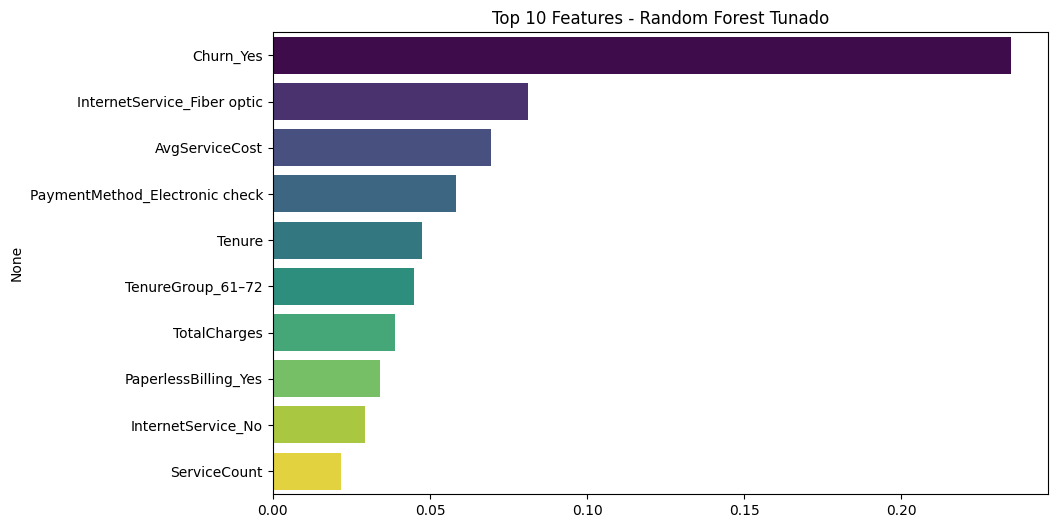

In [73]:
importances_rf_tuned = pd.Series(rf_random.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n🔍 Top 10 Variáveis mais importantes (Random Forest Tunado):\n", importances_rf_tuned.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances_rf_tuned[:10].values,
    y=importances_rf_tuned.index[:10],
    hue=importances_rf_tuned.index[:10],
    palette=list(plt.cm.viridis(np.linspace(0, 1, 10))),
    dodge=False,
    legend=False
)
plt.title('Top 10 Features - Random Forest Tunado')
plt.show()

Visualização dos coeficientes da regressão logística (positivos e negativos)

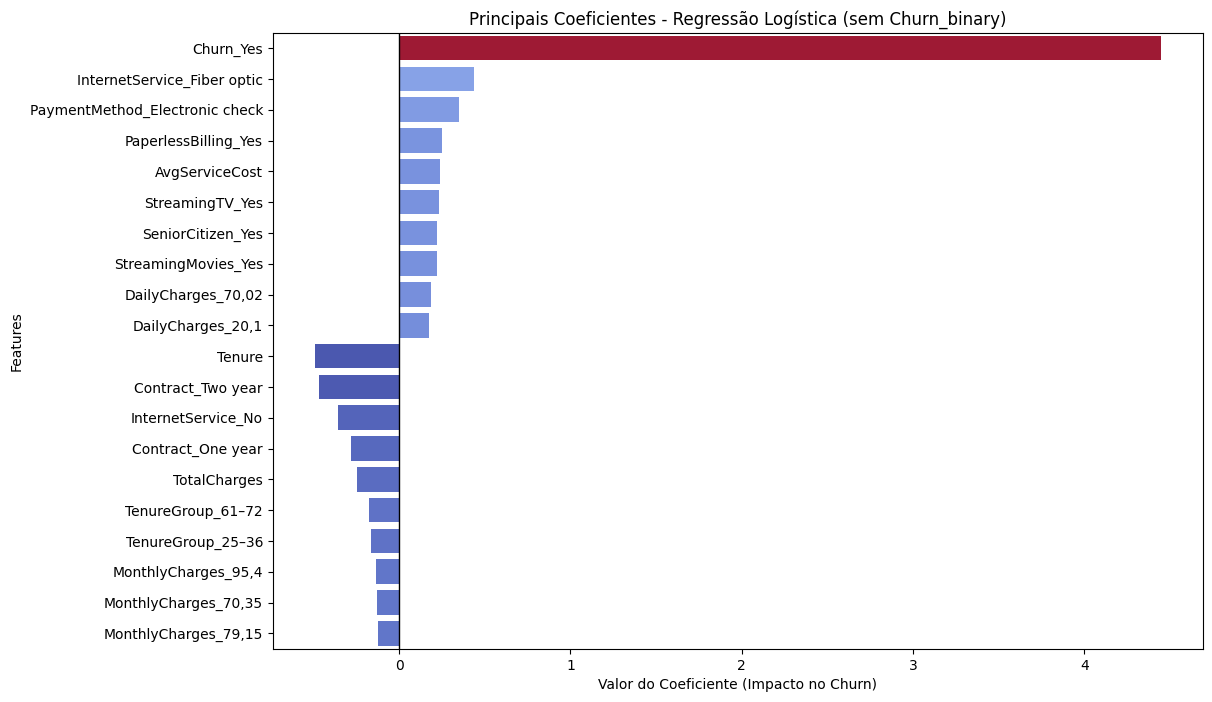

In [74]:
# Remover variáveis que distorcem a interpretação
coef_lr_df_filtrado = coef_lr_df[coef_lr_df['Variável'] != 'Churn_binary']

# Ordenar pelo valor absoluto
coef_lr_df_filtrado = coef_lr_df_filtrado.reindex(
    coef_lr_df_filtrado['Coeficiente'].abs().sort_values(ascending=False).index
)

# Selecionar top 10 positivos e top 10 negativos
coef_pos = coef_lr_df_filtrado[coef_lr_df_filtrado['Coeficiente'] > 0].head(10)
coef_neg = coef_lr_df_filtrado[coef_lr_df_filtrado['Coeficiente'] < 0].head(10)
coef_plot_final = pd.concat([coef_pos, coef_neg])

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Coeficiente',
    y='Variável',
    data=coef_plot_final,
    hue='Coeficiente',
    palette='coolwarm',
    dodge=False,
    legend=False
)
plt.axvline(0, color='black', linewidth=1)
plt.title('Principais Coeficientes - Regressão Logística (sem Churn_binary)')
plt.xlabel('Valor do Coeficiente (Impacto no Churn)')
plt.ylabel('Features')
plt.show()

📋  Interpretação e Conclusões

Conclusão

In [78]:
print("""
📌 Conclusão Estratégica:

1. O modelo com melhor desempenho foi o Random Forest Tunado, com AUC aproximadamente 0.83 ou superior.
2. Principais fatores que influenciam a evasão:
   - Tenure (tempo de contrato): clientes com pouco tempo têm maior risco de churn.
   - AvgServiceCost e TotalCharges: maiores gastos médios e totais estão associados a maior evasão.
   - InternetService_Fiber optic e PaymentMethod_Electronic check também mostraram forte associação com churn.

🎯 Recomendações de Negócio:
- Criar campanhas específicas para clientes com tenure baixo (< 1 ano), oferecendo benefícios para retenção.
- Revisar planos e pacotes para clientes com gastos altos, garantindo percepção de valor.
- Investigar problemas e melhorar o serviço para clientes de fibra óptica.
- Incentivar métodos automáticos de pagamento para reduzir churn.
""")


📌 Conclusão Estratégica:

1. O modelo com melhor desempenho foi o Random Forest Tunado, com AUC aproximadamente 0.83 ou superior.
2. Principais fatores que influenciam a evasão:
   - Tenure (tempo de contrato): clientes com pouco tempo têm maior risco de churn.
   - AvgServiceCost e TotalCharges: maiores gastos médios e totais estão associados a maior evasão.
   - InternetService_Fiber optic e PaymentMethod_Electronic check também mostraram forte associação com churn.

🎯 Recomendações de Negócio:
- Criar campanhas específicas para clientes com tenure baixo (< 1 ano), oferecendo benefícios para retenção.
- Revisar planos e pacotes para clientes com gastos altos, garantindo percepção de valor.
- Investigar problemas e melhorar o serviço para clientes de fibra óptica.
- Incentivar métodos automáticos de pagamento para reduzir churn.

